In [1]:
import pandas as pd
import shapely
import numpy as np
import geopandas as gpd
import requests
import itertools
from shapely.ops import cascaded_union
import matplotlib
import matplotlib.pyplot as plt
import random
shapely.speedups.disable()
%load_ext autoreload
%autoreload 2

In [2]:
from helper_functions.hazard_maps_helper import *
from helper_functions.mapbox_helper import *
from helper_functions.data_prep_helper import *
from helper_functions.candidate_generation_helper import *
from helper_functions.demand_helper import *
from helper_functions.hrsl_site_helper import *
from helper_functions.metrics_helper import *
from helper_functions.plot_helper import *

MapBox Access: 


 pk.eyJ1IjoibGp5Zmxvb3JlcyIsImEiOiJja2xidnFiZnEwajdsMndwMG1wZXR3NXNsIn0.e_MqDuNDb4CgPitZSBtirg


Google Access Key:


## Read in Data

In [3]:
HOSP_PATH = "data/RHUs_antipolo.csv"
HOSP_province_name = 'ANTIPOLO'

SHAPEFILES_MUN_PATH = "muni/MuniCities.shp"
SHAPEFILES_name_1 = 'Antipolo'

WORLD_POP_PATH = "data/ph_worldpop_population.csv"
new_run = 0

In [4]:
# Read in hospitals
hosp = pd.read_csv(HOSP_PATH)
hosp = gpd.GeoDataFrame(hosp,
                 geometry=[shapely.geometry.Point(x,y) for (x,y) in zip(hosp.lon,hosp.lat)],
                 crs='EPSG:4326')

# Subset hospitals
hosp = hosp.loc[hosp['City/Municipality Name'].str.contains(HOSP_province_name)].reset_index(drop=True)

# Read in shapefiles
mun = gpd.read_file(SHAPEFILES_MUN_PATH, crs='EPSG:4326')

# Subset shapefiles
mun = mun.loc[mun['NAME_2'].str.contains(SHAPEFILES_name_1)]
mun = gpd.GeoDataFrame(mun, geometry='geometry', crs='EPSG:4326')

# Merge all shapefile polygons into 1 row
union = cascaded_union(mun['geometry'])
mun = mun.reset_index(drop=True)
mun.loc[0,'geometry'] = None
mun['geometry'][0] = union
mun = mun.loc[[0]]

# Reread in Subsetted World Pop/HRSL Dataframe 
hrsl = pd.read_csv(f'data/hrsl_data/{SHAPEFILES_name_1.lower()}.csv')
hrsl['geometry'] = hrsl['geometry'].apply(shapely.wkt.loads)
hrsl = gpd.GeoDataFrame(hrsl, geometry=hrsl['geometry'], crs='EPSG:4326')
hrsl_copy = hrsl.copy()
    
# Load in the hospital isochrones
hosp30 = pd.read_csv(f"data/hosp30_{SHAPEFILES_name_1.lower()}.csv")
hosp30['geometry'] = hosp30['geometry'].apply(shapely.wkt.loads)
hosp30 = gpd.GeoDataFrame(hosp30, geometry=hosp30['geometry'], crs='EPSG:4326')
hosp30['i30'] = hosp30['i30'].apply(shapely.wkt.loads)
hosp30 = gpd.GeoDataFrame(hosp30, geometry=hosp30['i30'], crs='EPSG:4326')

(121.09146664355468,
 121.42693048535168,
 14.547147340188593,
 14.758339856039548)

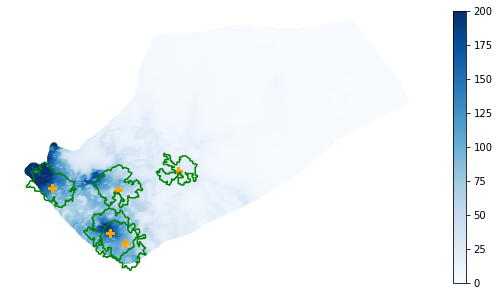

In [5]:
# Plot overview
norm = matplotlib.colors.Normalize(0,200,clip=True)

ax = mun.plot(color='white', edgecolor='black', linewidth=0.25, figsize=(10,5))
hrsl.plot(ax=ax, column='population_2020', cmap='Blues', alpha=1,
          norm=norm, legend=True)
hosp.plot(ax=ax, color='orange', marker='P', markersize=50)
hosp30.boundary.plot(ax=ax, color='green')
ax.axis('off')

## Generate Candidate Site Sets

<AxesSubplot:>

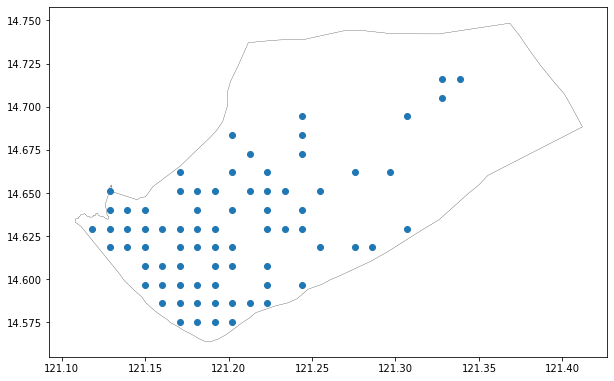

In [6]:
# Load in candidate sites
all_sites = pd.read_csv(f"data/all_sites_{SHAPEFILES_name_1.lower()}.csv")
all_sites['geometry'] = all_sites['geometry'].apply(shapely.wkt.loads)
all_sites = gpd.GeoDataFrame(all_sites, geometry=all_sites['geometry'], crs='EPSG:4236')
    
# Reset indices, only keep points near roads
all_sites = all_sites.loc[all_sites['road_distance'].notnull()]
all_sites = all_sites.reset_index(drop=True)
all_sites['index'] = list(range(all_sites.shape[0]))

# Plot
ax = mun.plot(color='white', edgecolor='black', linewidth=0.25, figsize=(10,15))
all_sites.plot(ax=ax, figsize=(10,10))

### Set-Up: Site and Site Set Generation

In [9]:
# Candidate Sites
sites = pd.read_csv(f"data/sites_{SHAPEFILES_name_1.lower()}.csv")
sites['geometry'] = sites['geometry'].apply(shapely.wkt.loads)
sites['coords'] = sites['coords'].apply(shapely.wkt.loads)
sites = gpd.GeoDataFrame(sites, geometry=sites['geometry'], crs='EPSG:4236')

# Prepare site_coords to keep track of chosen site's coordinates
site_coords = gpd.GeoDataFrame(sites.copy(), geometry=sites['coords'], crs='EPSG:4326')
site_coords = {key:val for (key,val) in zip(site_coords['index'],site_coords['geometry'])}

# Sample set sites
set_size = 5
num_sets = len(list(site_coords.keys()))
redundant_d = generate_redundant_sites(sites['coords'])
site_sets = sample_sets(list(site_coords.keys()), int(set_size), 100000, redundant_d)

Generating candidates
Generating dataframe


In [31]:
# RHUs

# Prepare site_coords to keep track of chosen site's coordinates
site_coords = hosp.copy().reset_index()
site_coords = {key:val for (key,val) in zip(site_coords['index'],site_coords['geometry'])}

# Sample set sites
set_size = 5
num_sets = len(list(site_coords.keys()))
redundant_d = generate_redundant_sites(sites['coords'])
site_sets = sample_sets(list(site_coords.keys()), int(set_size), "all", redundant_d)

Generating candidates
Generating dataframe


### Set-Up: Downsample HRSL

In [11]:
# Aggregate by kilometer
hrsl['longitude'] = hrsl['longitude'].apply(lambda x: round(x,2))
hrsl['latitude'] = hrsl['latitude'].apply(lambda x: round(x,2))
hrsl = hrsl.groupby(['longitude','latitude']).aggregate({'population_2020':sum}).reset_index()

# Dataframe
hrsl['geometry'] = [shapely.geometry.Point(x,y) for (x,y) in zip(hrsl['longitude'],hrsl['latitude'])]
hrsl = gpd.GeoDataFrame(hrsl, geometry=hrsl['geometry'], crs='EPSG:4326')

### Set-Up: Store Site Set-HRSL info in Dictionaries

In [12]:
# Original Demand
site_hrsl = make_site_hrsl_dict(sites, hrsl)
site_set_hrsl = make_site_set_hrsl_dict(site_hrsl, site_sets.copy())
site_set_hrsl = add_coords(site_set_hrsl, site_coords)

## Optimization Methods

### Metric 1: Population Covered within 30 Mins

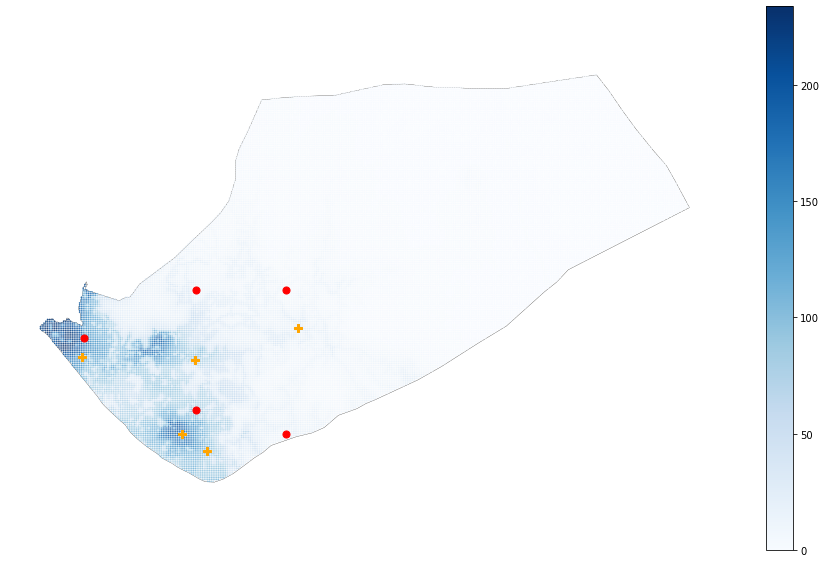

In [21]:
result_1A = mapreduce(site_set_hrsl.copy(), compute_metric_population_single)
plot_result(result_1A, mun, background=True, hrsl=hrsl_copy, hrsl_col='population_2020', hosp=hosp, height=10, width=16)
print(result_1A[1])

### Metric 2: Distance Decay (Jia et al., 2019)

#### Set-Up: Subsetting & Drive Time Calculation

In [16]:
# Load in travel time matrix (RHU/candidate to HRSL point)
time_matrix = pd.read_csv(f"data/time_matrix_{SHAPEFILES_name_1.lower()}.csv")
time_matrix = time_matrix.values
time_matrix_saved = time_matrix.copy()

### Compute: Metric 2

13583.751482800888


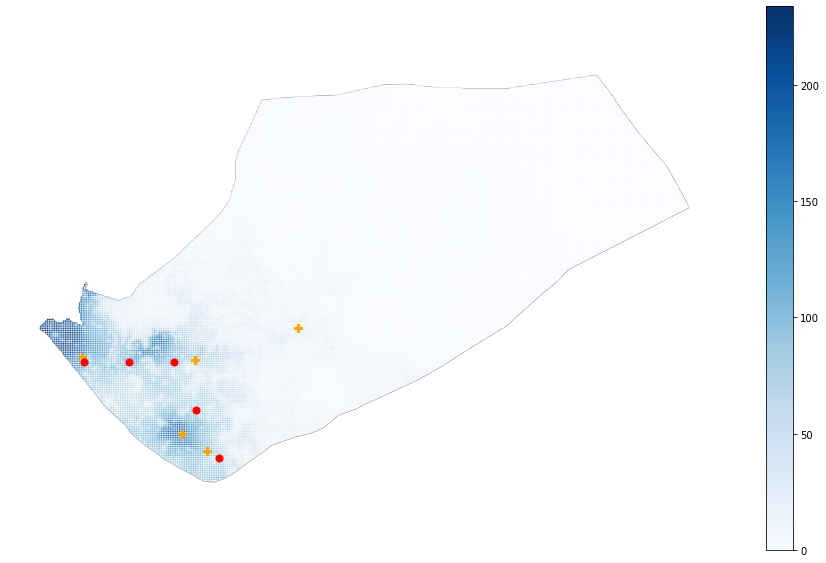

In [22]:
# Compute expected demand
demand_2a_1 = compute_exp_demand(hrsl['population_2020'], time_matrix_saved, 
                                beds=20, u=0.20, a=0.66,
                                s=0.40, b=2.14, t=6.29)
# Compute number of visitors attracted by each site set, determine best
result_2b_A_1 = mapreduce(site_set_hrsl.copy(), 
                          lambda dct: compute_metric_dist_decay_single(dct,
                                                                       hrsl['population_2020'], 
                                                                       demand_2a_1))
plot_result(result_2b_A_1, mun, background=True, hrsl=hrsl_copy, hrsl_col='population_2020', hosp=hosp, height=10, width=16)
print(result_2b_A_1[1])